# DSCI 592 Capstone II: Group Project
## Team: Safe CIty
## NY-Bronx  (Clustering)

In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA

# to make this notebook's output identical at every run
np.random.seed(42)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Import the data as Pandas DataFrame as follows
df = pd.read_csv("df_bronx_zip_law.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FELONY       25 non-null     int64  
 1   MISDEMEANOR  25 non-null     int64  
 2   VIOLATION    25 non-null     int64  
 3   Crime        25 non-null     int64  
 4   zip          25 non-null     int64  
 5   latitude     25 non-null     float64
 6   longitude    25 non-null     float64
dtypes: float64(2), int64(5)
memory usage: 1.5 KB


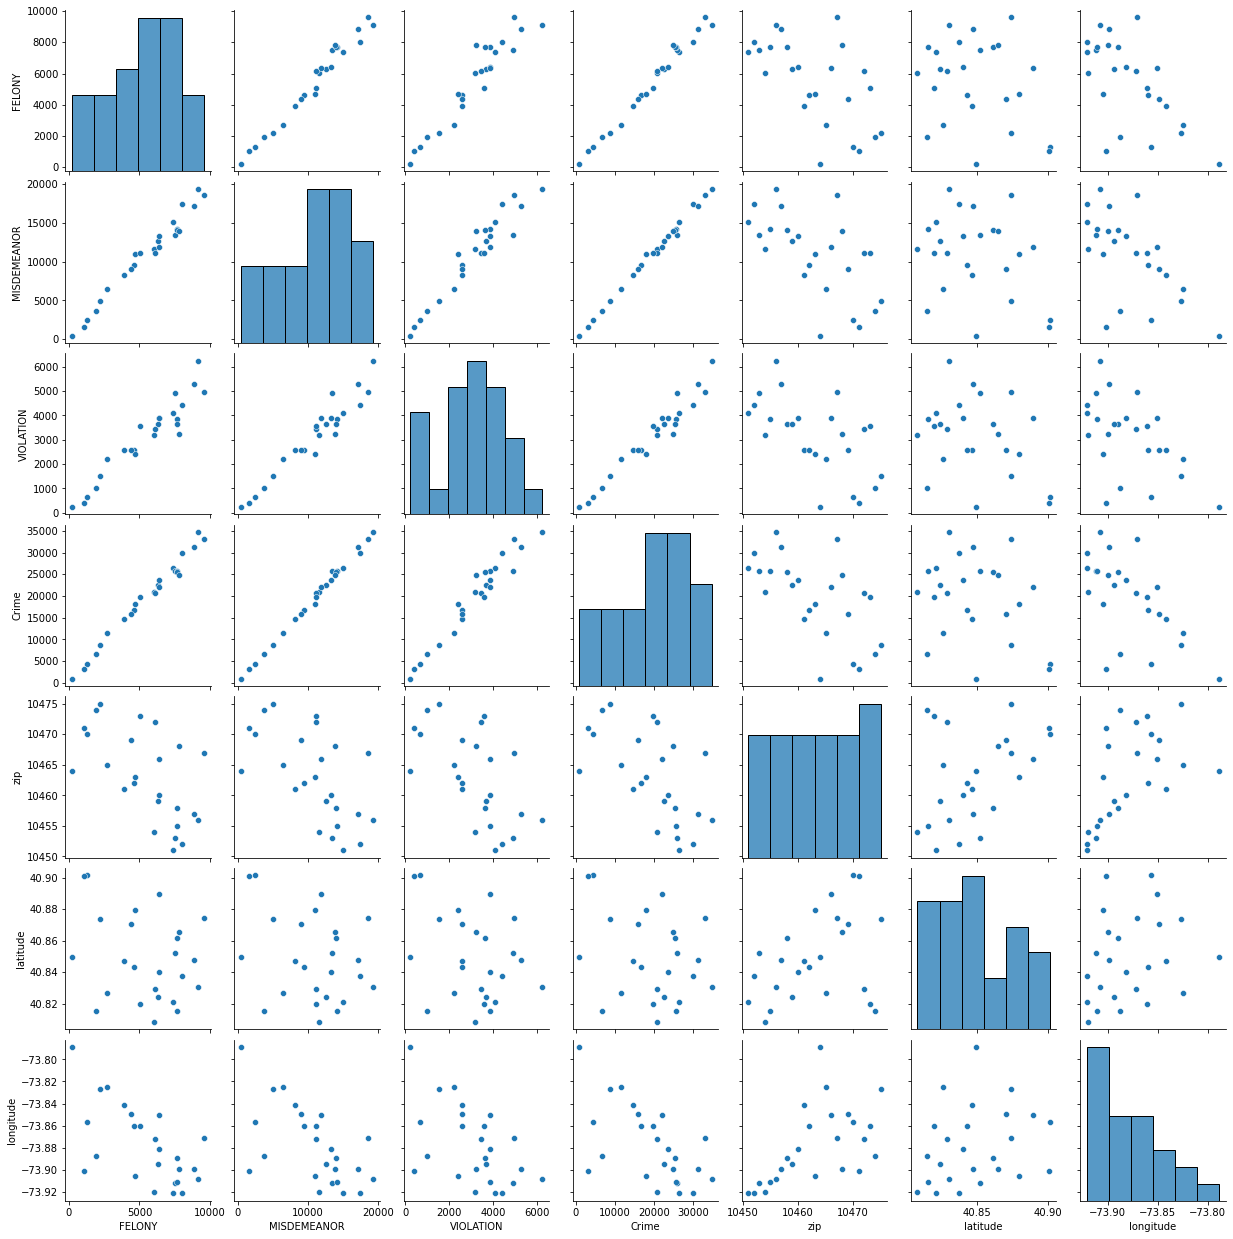

In [4]:
sns.pairplot(df)

## 1. K-Means

- Drop zip code column

In [5]:
df2 = df.copy()
df2.drop('zip', axis=1, inplace=True)
df2.head()

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude
0,7348,15042,4106,26496,40.821109,-73.920985
1,7991,17451,4419,29861,40.837664,-73.921406
2,7494,13431,4918,25843,40.852023,-73.911923
3,6045,11657,3179,20881,40.808346,-73.919634
4,7670,14203,3860,25733,40.815511,-73.911388


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(df2)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_scaled) for k in range(2, 7)]
inertias = [model.inertia_ for model in kmeans_per_k]

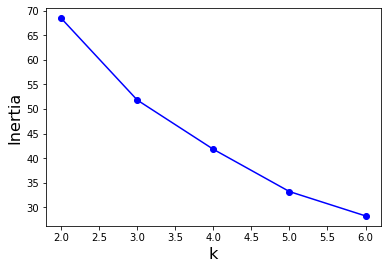

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 7), inertias, "bo-")
plt.xlabel("k", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.show()

In [8]:
# Computation of silhouette sores
silhouette_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_per_k]

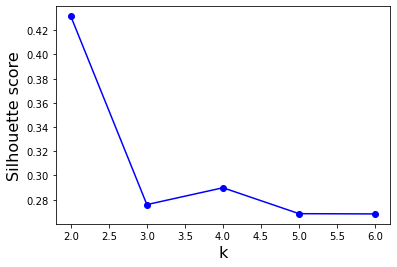

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 7), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=16)
plt.ylabel("Silhouette score", fontsize=16)
plt.show()

## 4-Cluster result

In [10]:
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

In [11]:
# Scatter plot of 4-cluster result
# X_scaled: scaled X variables
# yr: cluster labels
# column name of X variables
# x: x-label to plot
# y: y-label to plot
def plot_4c(X_s, yr, cols, x, y):
    nx = cols.index(x)
    ny = cols.index(y)
    plt.scatter(X_s[:,nx][yr==3], X_s[:,ny][yr==3],
             marker='s', c = 'c', s = 50, alpha = 0.6)
    plt.scatter(X_s[:,nx][yr==2], X_s[:,ny][yr==2],
              marker='^', c = 'g', s = 70, alpha = 0.6)
    plt.scatter(X_s[:,nx][yr==1], X_s[:,ny][yr==1],
              marker='+', c = 'm', s = 90, alpha = 0.6)
    plt.scatter(X_s[:,nx][yr==0], X_s[:,ny][yr==0],
              marker='D', c = 'r', s = 50, alpha = 0.6)
    plt.xlabel(x,fontsize=14)
    plt.ylabel(y,fontsize=14)
    plt.legend(["C3","C2","C1","C0"],fontsize=14)

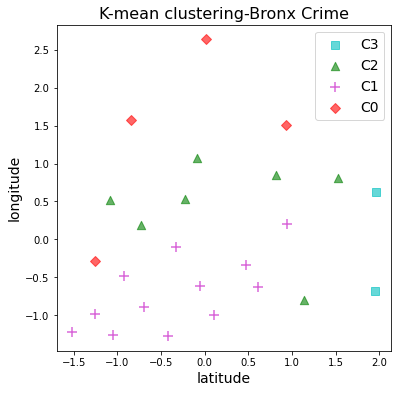

In [12]:
cols = list(df2)
plt.figure(figsize=(6,6))
plot_4c(X_scaled, kmeans_4.labels_, cols, 'latitude', 'longitude')
plt.title('K-mean clustering-Bronx Crime', fontsize = 16)
plt.show()

### Cluster center

In [13]:
cols = list(df2)
kmeans_center_df = pd.DataFrame(kmeans_4.cluster_centers_, columns=cols)
kmeans_center_df

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude
0,-1.404729,-1.355638,-1.252725,-1.363752,-0.290621,1.359568
1,0.838571,0.810189,0.753552,0.815563,-0.342213,-0.713438
2,-0.169588,-0.121847,-0.083231,-0.130171,0.193235,0.454326
3,-1.628410,-1.723394,-1.724551,-1.710277,1.958196,-0.028651


In [14]:
table1 = df2.describe()
table1[:3]

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,5474.840000,10897.680000,3145.040000,19517.560000,40.849024,-73.878191
std,2697.784626,5248.023435,1545.557302,9415.376356,0.027286,0.034651


### Scaled cluster center

In [15]:
# Scaled cluster center
kmeans_center_scale_df = kmeans_center_df.copy()
for i in cols:
    kmeans_center_scale_df[i] = kmeans_center_scale_df[i]*table1[i][2]+table1[i][1]
    
kmeans_center_scale_df = kmeans_center_scale_df.astype({"FELONY":int, "MISDEMEANOR": int, "VIOLATION":int, "Crime": int})
kmeans_center_scale_df["cluster"] = kmeans_center_scale_df.index
kmeans_center_scale_df

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude,cluster
0,1685,3783,1208,6677,40.841094,-73.831080,0
1,7737,15149,4309,27196,40.839686,-73.902912,1
2,5017,10258,3016,18291,40.854296,-73.862448,2
3,1081,1853,479,3414,40.902455,-73.879183,3


### Scaled cluster center/mean value

In [16]:
# Scaled cluster center (normalized by mean)
table1 = df2.describe()
cols = list(df2)
kmeans_center_ratio_df = kmeans_center_scale_df.copy()
for i in cols:
    kmeans_center_ratio_df[i] = (kmeans_center_df[i]*table1[i][2]+table1[i][1])/table1[i][1]

kmeans_center_ratio_df["cluster"] = kmeans_center_scale_df.index
kmeans_center_ratio_df

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude,cluster
0,0.307805,0.347162,0.384377,0.342119,0.999806,0.999362,0
1,1.413215,1.390165,1.370316,1.393432,0.999771,1.000335,1
2,0.916434,0.941322,0.959098,0.937205,1.000129,0.999787,2
3,0.197584,0.170061,0.152509,0.174953,1.001308,1.000013,3


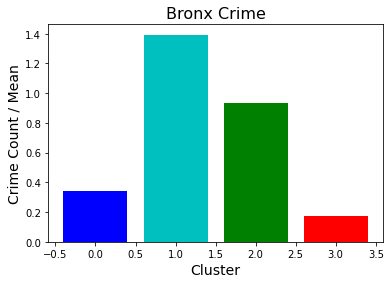

In [17]:
plt.figure(figsize=(6,4))
plt.bar(kmeans_center_ratio_df['cluster'],kmeans_center_ratio_df['Crime'],color=['b','c', 'g','r','y'])
plt.xlabel("Cluster",fontsize=14)
plt.ylabel("Crime Count / Mean",fontsize=14)
#plt.grid()
plt.title('Bronx Crime', fontsize = 16)
plt.show()

## Append 4-cluster result to the dataframe

In [18]:
label = kmeans_4.labels_
df["K_mean"] = label
df.head()

,FELONY,MISDEMEANOR,VIOLATION,Crime,zip,latitude,longitude,K_mean
0,7348,15042,4106,26496,10451,40.821109,-73.920985,1
1,7991,17451,4419,29861,10452,40.837664,-73.921406,1
2,7494,13431,4918,25843,10453,40.852023,-73.911923,1
3,6045,11657,3179,20881,10454,40.808346,-73.919634,1
4,7670,14203,3860,25733,10455,40.815511,-73.911388,1


In [19]:
# Write to a csv file
df.to_csv("df_bronx_k4.csv", index = False)

## Append 4 cluster result to df_bronx.csv

In [20]:
# Make zip to cluster conversion dictionary
bronx_zip_cluster4 = []
for i in range(len(df)):
    bronx_zip_cluster4.append([df['zip'].iloc[i], df['K_mean'].iloc[i]])
bronx_zip_cluster4_dict = dict(bronx_zip_cluster4)

df_b = pd.read_csv("df_bronx.csv")
df_b['cluster'] = df_b['Zip'].apply(lambda x: bronx_zip_cluster4_dict[x])

# Write to a csv file
df_b.to_csv("df_bronx_c4.csv", index = False)

### Cluster-Zip code

In [21]:
df_select = df[['zip','K_mean']]
cluster_zip_list = [] 
for cluster in range(4):
    cluster_zip_list.append(
        (cluster, list(df_select[df['K_mean']==cluster]['zip'])))
cluster_zip_dict =  dict(cluster_zip_list)

In [22]:
for cluster in range(4):
    print(cluster, cluster_zip_dict[cluster])

0 [10464, 10465, 10474, 10475]
1 [10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10467, 10468]
2 [10461, 10462, 10463, 10466, 10469, 10472, 10473]
3 [10470, 10471]


In [23]:
pd.DataFrame(cluster_zip_dict.items(),
            columns=['Cluster','Zip Code'])

,Cluster,Zip Code
0,0,"[10464, 10465, 10474, 10475]"
1,1,"[10451, 10452, 10453, 10454, 10455, 10456, 104..."
2,2,"[10461, 10462, 10463, 10466, 10469, 10472, 10473]"
3,3,"[10470, 10471]"
